# Crunch 1 - Exploratory Analysis for Spatial Transcriptomics Prediction

## Purpose of This Notebook
This notebook is intended to facilitate an exploratory analysis of the data provided for **Crunch 1** of the Autoimmune Disease Machine Learning Challenge. The purpose of this analysis is to:
- Understand the structure and characteristics of the datasets.
- Validate the integrity and alignment of the data.
- Identify patterns and relationships between the input data (`X`: H&E images) and output data (`Y`: spatial transcriptomics).
- Provide a foundation for preprocessing steps, feature engineering, and model development.

Exploratory data analysis (EDA) involves systematically reviewing and visualizing data to uncover meaningful insights. It is a critical step in any data science workflow, particularly when working with complex datasets like those in this challenge.

## Objectives

1. **Dataset Inspection**:
   - The structure and contents of the datasets will be examined. This includes reviewing `HE_registered`, `HE_original`, `anucleus`, and `transcripts`.
   - Potential issues, such as missing data or misaligned images, will be identified.

2. **Visualization**:
   - The spatial organization of nuclei and gene expression in tissue regions will be explored.
   - H&E image data will be visualized alongside transcriptomics data to understand how these modalities relate to each other spatially.

3. **Statistical Analysis**:
   - Distributions of gene expression and image features will be summarized.
   - Correlations and patterns between the input (`X`) and output (`Y`) datasets will be analyzed to guide the development of features for modeling.

## Inputs and Outputs
### **Inputs (`X`)**
1. **HE_registered**: These are H&E pathology images that have been registered to the coordinate system used by the spatial transcriptomics data. Registration ensures that the images are aligned with the gene expression measurements and simplifies downstream analysis. This dataset is recommended as it avoids the need for additional alignment.
2. **HE_original**: These are the unaligned H&E images in their native pixel coordinates. While alignment may need to be performed manually, these images could provide additional flexibility for advanced preprocessing tasks.

### **Outputs (`Y`)**
1. **anucleus**: This dataset contains aggregated gene expression profiles for 460 genes, with one profile for each nucleus. The gene expression data has been log1p-normalized, a transformation that makes the data more manageable for machine learning by compressing large values and emphasizing smaller ones.
2. **transcripts**: This dataset provides raw spatial transcriptomics data, including the expression levels of individual genes and their spatial locations within the tissue. These data are linked to specific nuclei and are aggregated to produce `anucleus`.

## Success Metrics
The goal of this analysis is to ensure that the datasets are ready for use in developing a predictive model. The ultimate objective of the challenge is to predict gene expression in regions of tissue where this information is held out.

- **End Goal**: The prediction of log1p-normalized gene expression for 460 genes in held-out regions of the tissue.
- **Evaluation Metric**: The predictions will be assessed using the Mean Squared Error (MSE), which measures the average squared difference between the predicted and actual gene expression values.

By the conclusion of this notebook, the datasets will have been thoroughly explored, and actionable insights will have been generated to inform preprocessing, feature engineering, and model development.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import spatialdata_plot
import spatialdata as sd
import scanpy as sc

/home/secondbook5/micromamba/envs/autoimmune_ml/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [3]:
from src.config.config_loader import ConfigLoader
from pathlib import Path

# Step 1: Initialize the ConfigLoader with the relative path to config.yaml
config_loader = ConfigLoader("../../config.yaml")

# Step 2: Retrieve the raw_dir for Crunch 1 from the configuration
raw_dir = config_loader.get_crunch_path("crunch1", "raw_dir")

# Step 3: Construct the full path to the .zarr file
zarr_file_path = Path(raw_dir) / "UC1_NI.zarr"

# Step 4: Load the .zarr file using spatialdata
sdata = sd.read_zarr(str(zarr_file_path))

# Step 5: Output the spatial data
print(sdata)

SpatialData object, with associated Zarr store: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data/UC1_NI.zarr
├── Images
│     ├── 'DAPI': DataArray[cyx] (1, 51060, 53998)
│     ├── 'DAPI_nuc': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 21000, 22000)
│     ├── 'HE_nuc_registered': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_original': DataArray[cyx] (3, 21000, 22000)
│     ├── 'HE_registered': DataArray[cyx] (3, 51060, 53998)
│     ├── 'group': DataArray[cyx] (1, 51060, 53998)
│     └── 'group_HEspace': DataArray[cyx] (1, 21000, 22000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (2D points)
└── Tables
      ├── 'anucleus': AnnData (80037, 460)
      └── 'cell_id-group': AnnData (93686, 0)
with coordinate systems:
    ▸ 'global', with elements:
        DAPI (Images), DAPI_nuc (Images), HE_nuc_original (Images), HE_nuc_registered (Images), HE_original (Images), HE_registered (Images), group (Images), group_HEspace (I

In [4]:
print("[INFO] Available image keys:", sdata.images.keys())


[INFO] Available image keys: KeysView({'DAPI': <xarray.DataArray 'image' (c: 1, y: 51060, x: 53998)> Size: 6GB
dask.array<from-zarr, shape=(1, 51060, 53998), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 408kB 0.5 1.5 2.5 3.5 ... 5.106e+04 5.106e+04 5.106e+04
  * x        (x) float64 432kB 0.5 1.5 2.5 3.5 ... 5.4e+04 5.4e+04 5.4e+04
Attributes:
    transform:  {'global': Identity }, 'DAPI_nuc': <xarray.DataArray 'image' (c: 1, y: 51060, x: 53998)> Size: 11GB
dask.array<from-zarr, shape=(1, 51060, 53998), dtype=uint32, chunksize=(1, 5792, 5792), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 408kB 0.5 1.5 2.5 3.5 ... 5.106e+04 5.106e+04 5.106e+04
  * x        (x) float64 432kB 0.5 1.5 2.5 3.5 ... 5.4e+04 5.4e+04 5.4e+04
Attributes:
    transform:  {'global': Identity }, 'HE_nuc_original': <xarray.DataArray 'image' (c: 1, y: 21000, x: 22000)> Size: 2GB
dask.ar

## Input (X) Data: H&E Images

This function takes a list of image keys and titles renders the images using SpatialData's visualization capabilities, and arranges them in a single row of subplots for side-by-side comparison.

The visualization works by rasterizing the data stored in the SpatialData object, which involves converting high-resolution vector-based spatial information into raster images that can be displayed on the screen.
This is essential for exploring large tissue images, ensuring that the details are clearly visible while keeping memory usage manageable.

How It Works:
- The function creates a grid of subplots, each corresponding to an image key.
- For each image key, the SpatialData object's `.pl.render_images` method is used to rasterize and display the image. This ensures compatibility with large images.
- Titles are added to the subplots for clarity.
- `tight_layout()` is called to prevent overlapping of subplot elements.
### 2.1 Visualizing H&E Image

In [ ]:
# Visualize the H&E images
def visualize_he_images(sdata, image_keys, titles, figsize=(20, 10)):
    """
    Visualize H&E images using SpatialData.

    Args:
        sdata (SpatialData): The spatial data object containing the images.
        image_keys (list): List of keys for the images to visualize (e.g., ["HE_nuc_original", "HE_original"]).
        titles (list): List of titles corresponding to the images.
        figsize (tuple): Figure size for the plots.
    """
    # Validate inputs
    if len(image_keys) != len(titles):
        raise ValueError("Length of image_keys must match length of titles.")

    # Create subplots
    fig, axes = plt.subplots(1, len(image_keys), figsize=figsize)
    axes = axes.flatten()

    for ax, key, title in zip(axes, image_keys, titles):
        # Render the image and show it in the subplot
        sdata.pl.render_images(key).pl.show(ax=ax, title=title, coordinate_systems="global")

    plt.tight_layout()
    plt.show()

# Example usage for the quickstarter images
visualize_he_images(
    sdata,
    image_keys=["HE_nuc_original", "HE_original"],
    titles=["H&E Registered Image", "H&E Original Image"]
)


INFO     Rasterizing image for faster rendering.                                                                   


#### 2.1.1 Analyze Pixel Intensities

[INFO] Image 'HE_nuc_original':
  - Shape: (1, 21000, 22000)
  - Mean Intensity: 850.95
  - Median Intensity: 0.00
  - Standard Deviation: 9992.67
  - Min Intensity: 0
  - Max Intensity: 162955


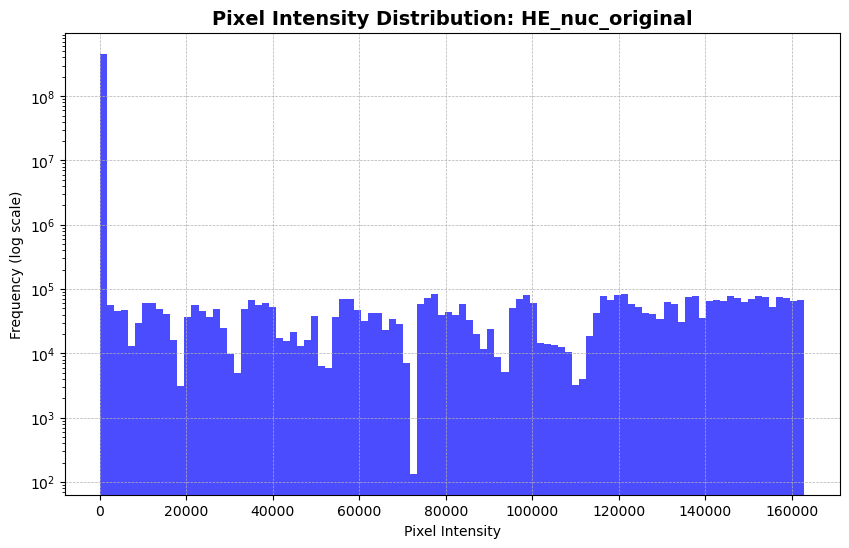

[INFO] Image 'HE_original':
  - Shape: (3, 21000, 22000)
  - Mean Intensity: 208.20
  - Median Intensity: 221.00
  - Standard Deviation: 41.07
  - Min Intensity: 12
  - Max Intensity: 255


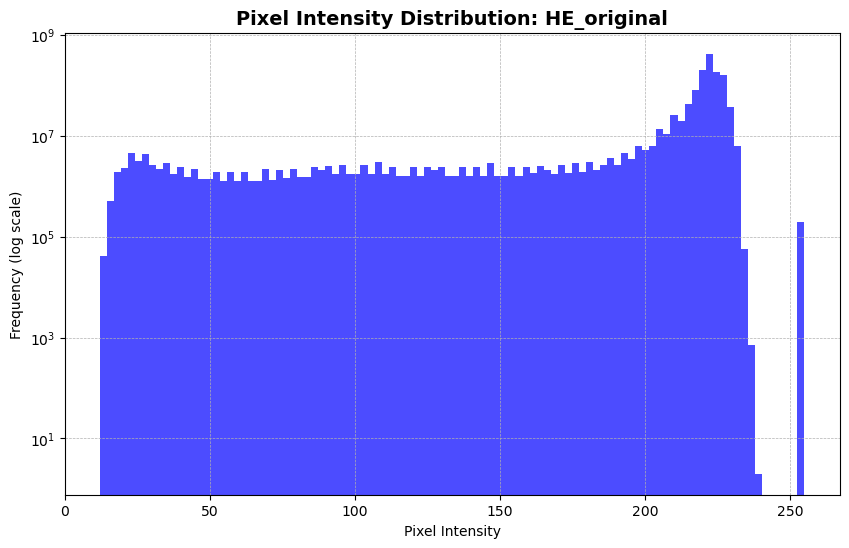

In [6]:
def analyze_pixel_intensities(sdata, keys):
    """
    Analyze pixel intensities and display their distribution for images.

    Args:
        sdata (SpatialData): The spatial data object.
        keys (list): Keys of the images to analyze.
    """
    for key in keys:
        # Extract the image as a NumPy array
        image = sdata.images[key].to_numpy()

        # Calculate statistics
        mean_intensity = image.mean()
        median_intensity = np.median(image)
        std_dev = image.std()
        min_intensity = image.min()
        max_intensity = image.max()
        shape = image.shape

        # Log statistics
        print(f"[INFO] Image '{key}':")
        print(f"  - Shape: {shape}")
        print(f"  - Mean Intensity: {mean_intensity:.2f}")
        print(f"  - Median Intensity: {median_intensity:.2f}")
        print(f"  - Standard Deviation: {std_dev:.2f}")
        print(f"  - Min Intensity: {min_intensity}")
        print(f"  - Max Intensity: {max_intensity}")

        # Plot histogram of pixel intensities
        plt.figure(figsize=(10, 6))
        plt.hist(image.flatten(), bins=100, color="blue", alpha=0.7, log=True)
        plt.title(f"Pixel Intensity Distribution: {key}", fontsize=14, fontweight="bold")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency (log scale)")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.show()

# Example usage
analyze_pixel_intensities(
    sdata,
    keys=["HE_nuc_original", "HE_original"]
)


### 2.2 Nuclei Overlay and Feature Analysis

In this section, we focus on analyzing nuclei features and overlaying their centroids on H&E images. The following tasks are performed to gain insights into the distribution and characteristics of nuclei in the dataset.

#### 2.2.1 Nuclei Overlay on H&E Images
This step involves overlaying the centroids of nuclei on the corresponding H&E image. This visualization helps to understand the spatial distribution of nuclei within the tissue.

**Code Explanation:**
- Validate the existence of required image keys in the dataset.
- Extract the original H&E image and nuclei mask using the specified keys.
- Compute centroids of the nuclei using `regionprops` from `skimage`.
- Plot the H&E image and overlay the nuclei centroids using scatter points.

**Results:**
- The overlay visualization confirms the spatial arrangement and density of nuclei across the tissue.
- The output highlights how nuclei are distributed in relation to the tissue structure.

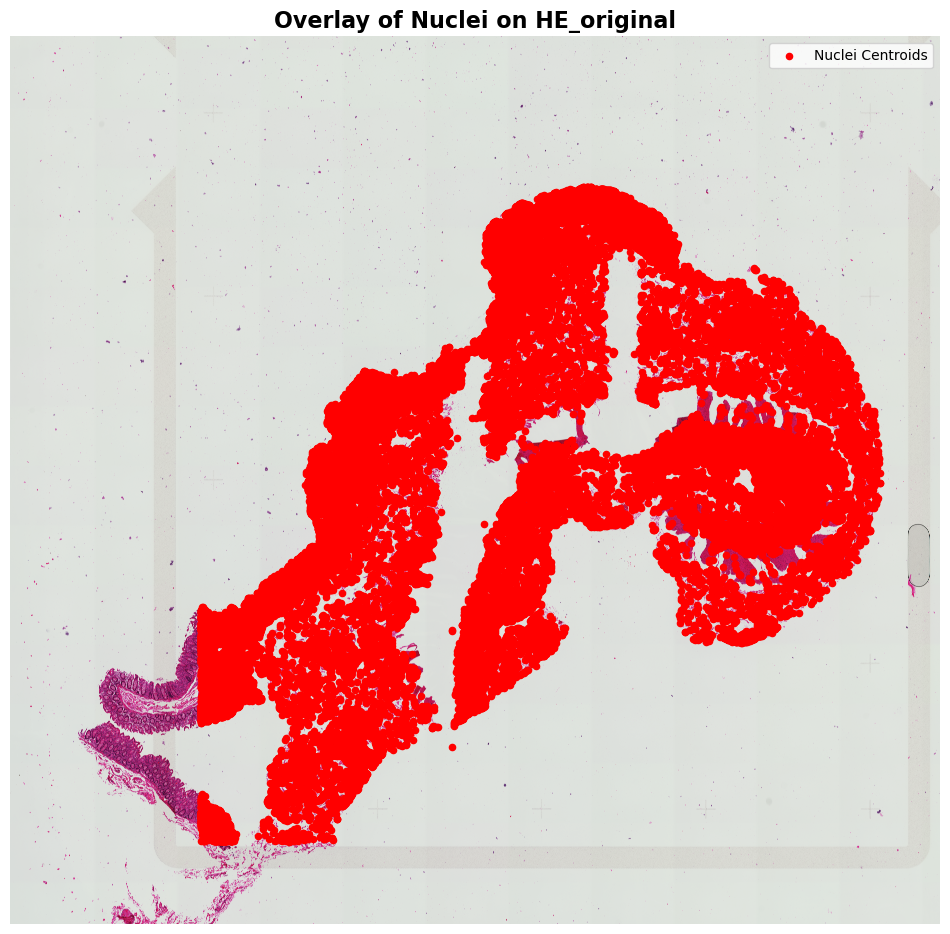

In [7]:


def plot_nuclei_overlay(sdata, image_key, nuclei_key="HE_nuc_original", marker_color="yellow", marker_size=15):
    """
    Overlay nuclei centroids on the H&E image.

    Args:
        sdata (SpatialData): The spatial data object.
        image_key (str): Key of the H&E image.
        nuclei_key (str): Key of the nuclei image.
        marker_color (str): Color of the markers for nuclei centroids.
        marker_size (int): Size of the markers for nuclei centroids.
    """
    # Validate input keys
    if image_key not in sdata.images.keys():
        raise KeyError(f"Image key '{image_key}' not found in SpatialData images.")
    if nuclei_key not in sdata.images.keys():
        raise KeyError(f"Nuclei key '{nuclei_key}' not found in SpatialData images.")

    # Load images
    image = sdata.images[image_key].to_numpy()
    nuclei = sdata.images[nuclei_key].to_numpy()

    # Handle image dimensions
    if image.shape[0] == 1:  # Grayscale with singleton channel
        image = image.squeeze(0)
    elif image.shape[0] == 3:  # RGB with three channels
        image = np.transpose(image, (1, 2, 0))

    if nuclei.shape[0] == 1:  # Grayscale nuclei image
        nuclei = nuclei.squeeze(0)

    # Extract nuclei centroids
    regions = regionprops(nuclei)
    centroids = [r.centroid for r in regions]

    if not centroids:
        print("[INFO] No nuclei centroids found in the provided nuclei image.")
        return

    # Plot the H&E image with overlay
    plt.figure(figsize=(12, 12))
    plt.imshow(image, cmap="gray" if image.ndim == 2 else None)  # Grayscale if 2D, otherwise RGB
    plt.scatter(
        [c[1] for c in centroids], [c[0] for c in centroids],
        c=marker_color, s=marker_size, label="Nuclei Centroids"
    )
    plt.title(f"Overlay of Nuclei on {image_key}", fontsize=16, fontweight="bold")
    plt.legend()
    plt.axis("off")
    plt.show()

# Example usage
plot_nuclei_overlay(
    sdata, image_key="HE_original", nuclei_key="HE_nuc_original",
    marker_color="red", marker_size=20
)


#### 2.2.2 Nuclei Feature Distribution and Analysis
In this step, we analyze key features of the nuclei such as their **area** and **eccentricity**. The analysis is visualized through histograms for easier interpretation.

**Code Explanation:**
- Compute the **area** and **eccentricity** of each nucleus using the `regionprops` method.
- Display summary statistics, including the total number of nuclei, mean, and median values for both area and eccentricity.
- Plot histograms to visualize the distributions of area and eccentricity.

**Key Metrics:**
- **Area**: Represents the size of each nucleus.
  - Mean Area: **46.24**
  - Median Area: **44.00**
- **Eccentricity**: Describes the elongation of the nucleus (value between 0 and 1, where 0 indicates a perfect circle).
  - Mean Eccentricity: **0.68**
  - Median Eccentricity: **0.71**

**Results:**
- The area distribution indicates most nuclei are between 30-70 units in size.
- Eccentricity distribution shows a bias towards higher eccentricity, suggesting elongated nuclei are common in this dataset.

---

**Figures:**
1. **Nuclei Area Distribution**:
   - A histogram showing the frequency of nuclei sizes.
   - Majority of nuclei fall within the 30-70 range, with a tail extending to larger sizes.

2. **Nuclei Eccentricity Distribution**:
   - A histogram displaying the frequency of eccentricity values.
   - The distribution peaks around 0.6-0.8, showing a prevalence of moderately elongated nuclei.


[INFO] Nuclei Feature Analysis:
 - Total Nuclei: 93866
 - Mean Area: 46.24
 - Median Area: 44.00
 - Mean Eccentricity: 0.68
 - Median Eccentricity: 0.71


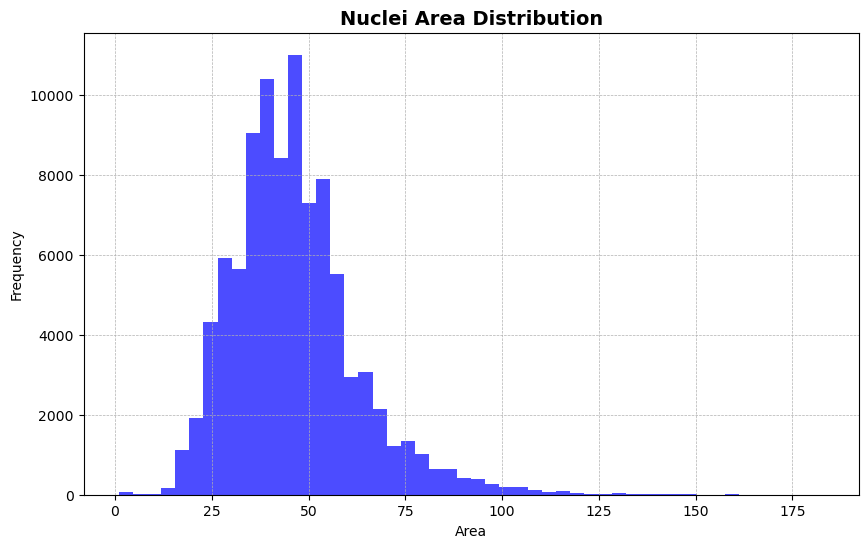

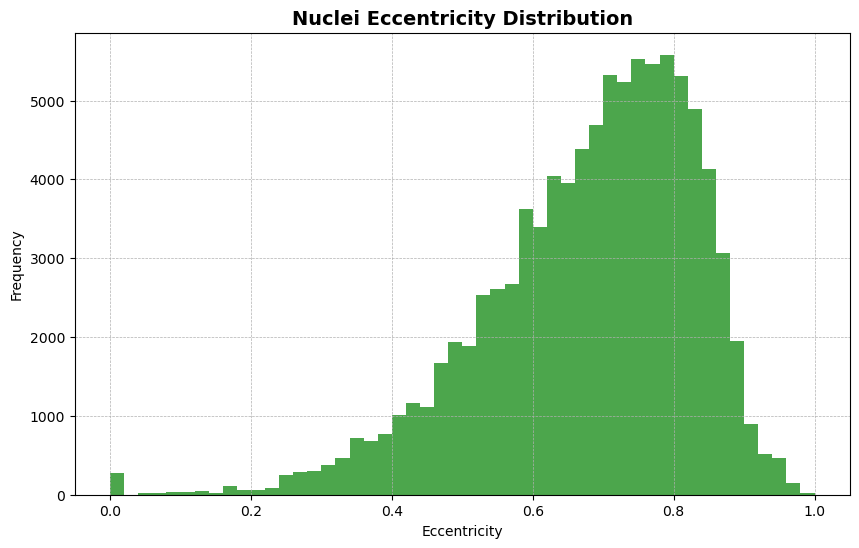

In [8]:


def analyze_nuclei_features(nuclei_image):
    """
    Analyze nuclei features such as area and eccentricity.

    Args:
        nuclei_image (np.ndarray): Binary nuclei image.

    Returns:
        None
    """
    # Label nuclei regions
    labeled_nuclei = label(nuclei_image)
    regions = regionprops(labeled_nuclei)

    areas = [r.area for r in regions]
    eccentricities = [r.eccentricity for r in regions]

    # Summary statistics
    print("\n[INFO] Nuclei Feature Analysis:")
    print(f" - Total Nuclei: {len(regions)}")
    print(f" - Mean Area: {np.mean(areas):.2f}")
    print(f" - Median Area: {np.median(areas):.2f}")
    print(f" - Mean Eccentricity: {np.mean(eccentricities):.2f}")
    print(f" - Median Eccentricity: {np.median(eccentricities):.2f}")

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(areas, bins=50, color="blue", alpha=0.7)
    plt.title("Nuclei Area Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("Area")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(eccentricities, bins=50, color="green", alpha=0.7)
    plt.title("Nuclei Eccentricity Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("Eccentricity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Example usage
nuclei_image = sdata.images["HE_nuc_original"].to_numpy().squeeze(0)
analyze_nuclei_features(nuclei_image)


### **2.3 Generate a Nuclei Density Heatmap**

A nuclei density heatmap provides insights into the spatial clustering and density of nuclei across the tissue section. This can be a valuable intermediate step for understanding tissue architecture.

---

#### **2.3.1 Dual Heatmap Approach**
### **Objective**:
To comprehensively analyze the nuclei density distribution using two complementary heatmaps:
1. A **localized hotspot heatmap** for precise high-density regions (Stage 1: Choice 1).
2. A **global context heatmap** for an inclusive overview of density patterns (Stage 2: Choice 2).

### **Approach**:
- The dual heatmap approach is broken into two stages, each offering unique strengths and addressing distinct aspects of the data.
- Combined, these heatmaps provide a balance between precision and comprehensiveness.

---

#### **Stage 1: High-Density Hotspot Heatmap (Choice 1)**
- Focuses on sharp, localized regions of extreme nuclei density.
- Utilizes dynamic thresholding to highlight the top 5% of density values.
- Offers detailed insights into biologically significant clusters, such as tumor hotspots or immune cell infiltrations.

---

#### **Stage 2: Global Context Heatmap (Choice 2)**
- Provides a broader perspective of the nuclei density distribution.
- Enhances visualization with contours, centroids, and optional background overlays for spatial context.
- Ideal for identifying general tissue architecture patterns and regions of moderate density.


[INFO] High-density mask saved to high_density_mask.png
[INFO] Summary Statistics:
  - Total High-Density Area: 4500.0000
  - Total Density: 0.0002
  - Mean Density: 0.0000
  - Max Density: 0.0000
  - Dynamic Threshold: 0.0000


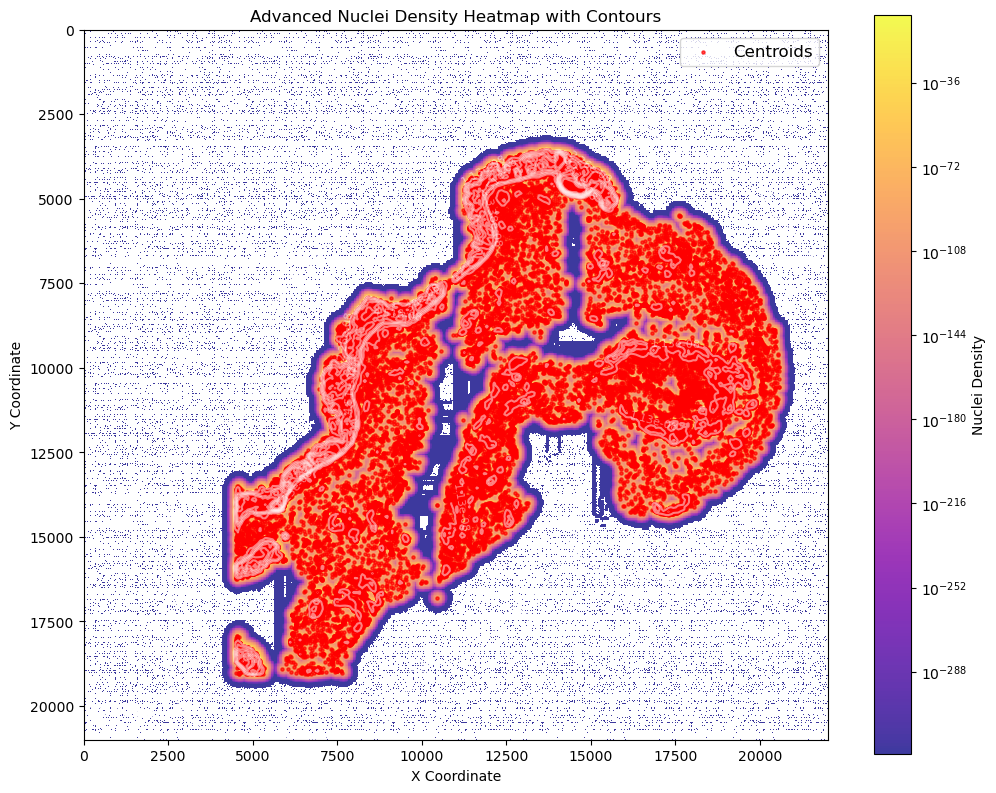

In [9]:


def generate_advanced_nuclei_density_heatmap(
        nuclei_image,
        bins=200,
        colormap="viridis",
        show_centroids=True,
        scale_bar=True,
        adaptive_bandwidth=True,
        dynamic_threshold=True,
        contour_features=True,
        save_masks=True,
        mask_output_path="high_density_mask.png"
):
    """
    Generate an advanced nuclei density heatmap with various enhancements.

    Args:
        nuclei_image (np.ndarray): Binary nuclei image.
        bins (int): Number of bins for the heatmap.
        colormap (str): Colormap for the heatmap visualization.
        show_centroids (bool): Overlay nuclei centroids on the heatmap.
        scale_bar (bool): Add a scale bar to the heatmap.
        adaptive_bandwidth (bool): Use adaptive bandwidth for KDE.
        dynamic_threshold (bool): Use dynamic thresholding to highlight high-density regions.
        contour_features (bool): Add enhanced contour features to the heatmap.
        save_masks (bool): Save binary masks of high-density regions.
        mask_output_path (str): Path to save the binary mask of high-density regions.

    Returns:
        dict: Summary statistics of the density map.
    """
    # Extract nuclei centroids
    labeled_nuclei = label(nuclei_image)
    regions = regionprops(labeled_nuclei)
    centroids = np.array([region.centroid for region in regions])

    if centroids.size == 0:
        print("[WARNING] No nuclei detected. Skipping heatmap generation.")
        return {}

    # KDE Setup
    x_dim, y_dim = nuclei_image.shape[1], nuclei_image.shape[0]
    x = np.linspace(0, x_dim, bins)
    y = np.linspace(0, y_dim, bins)
    X, Y = np.meshgrid(x, y)

    if adaptive_bandwidth:
        kde = KernelDensity(kernel="gaussian", bandwidth=50)
        kde.fit(centroids)
        grid = np.vstack([Y.ravel(), X.ravel()]).T
        Z = np.exp(kde.score_samples(grid)).reshape(X.shape)
    else:
        kde = gaussian_kde(centroids.T, bw_method="scott")
        Z = kde(np.vstack([Y.ravel(), X.ravel()])).reshape(X.shape)

    # Dynamic Thresholding
    if dynamic_threshold:
        threshold = np.percentile(Z, 95)  # Top 5% density regions
    else:
        threshold = np.mean(Z) + 2 * np.std(Z)

    # Create high-density mask
    high_density_mask = (Z > threshold).astype(np.uint8)

    if save_masks:
        cv2.imwrite(mask_output_path, high_density_mask * 255)
        print(f"[INFO] High-density mask saved to {mask_output_path}")

    # Summary Statistics
    total_high_density_area = np.sum(high_density_mask)
    total_density = np.sum(Z)
    mean_density = np.mean(Z)
    max_density = np.max(Z)
    stats = {
        "Total High-Density Area": total_high_density_area,
        "Total Density": total_density,
        "Mean Density": mean_density,
        "Max Density": max_density,
        "Dynamic Threshold": threshold,
    }

    print("[INFO] Summary Statistics:")
    for key, value in stats.items():
        print(f"  - {key}: {value:.4f}")

    # Plot Heatmap
    plt.figure(figsize=(12, 12))
    plt.imshow(
        Z, extent=(0, x_dim, y_dim, 0), cmap=colormap, alpha=0.8, norm=LogNorm()
    )
    plt.colorbar(label="Nuclei Density", shrink=0.8)
    plt.title("Advanced Nuclei Density Heatmap", fontsize=16, fontweight="bold")

    if contour_features:
        contours = plt.contour(
            X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 10), colors="white", alpha=0.5
        )
        plt.clabel(contours, inline=True, fontsize=8, fmt="%.2e")
        plt.title("Advanced Nuclei Density Heatmap with Contours")

    # Optionally overlay nuclei centroids
    if show_centroids:
        plt.scatter(
            centroids[:, 1],
            centroids[:, 0],
            c="red",
            s=5,
            label="Centroids",
            alpha=0.7,
        )
        plt.legend(loc="upper right", fontsize=12)

    # Add scale bar
    if scale_bar:
        bar_length = 1000  # Adjust length based on image resolution
        plt.hlines(
            y_dim - 500, 100, 100 + bar_length, colors="white", linestyles="solid", lw=3
        )
        plt.text(
            100,
            y_dim - 700,
            f"{bar_length}px",
            color="white",
            fontsize=12,
            fontweight="bold",
        )

    plt.grid(False)
    plt.axis("on")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

    return stats


# Example Usage
nuclei_image = sdata.images["HE_nuc_original"].to_numpy().squeeze(0)
stats = generate_advanced_nuclei_density_heatmap(
    nuclei_image,
    bins=300,
    colormap="plasma",
    show_centroids=True,
    save_masks=True,
    mask_output_path="high_density_mask.png",
)


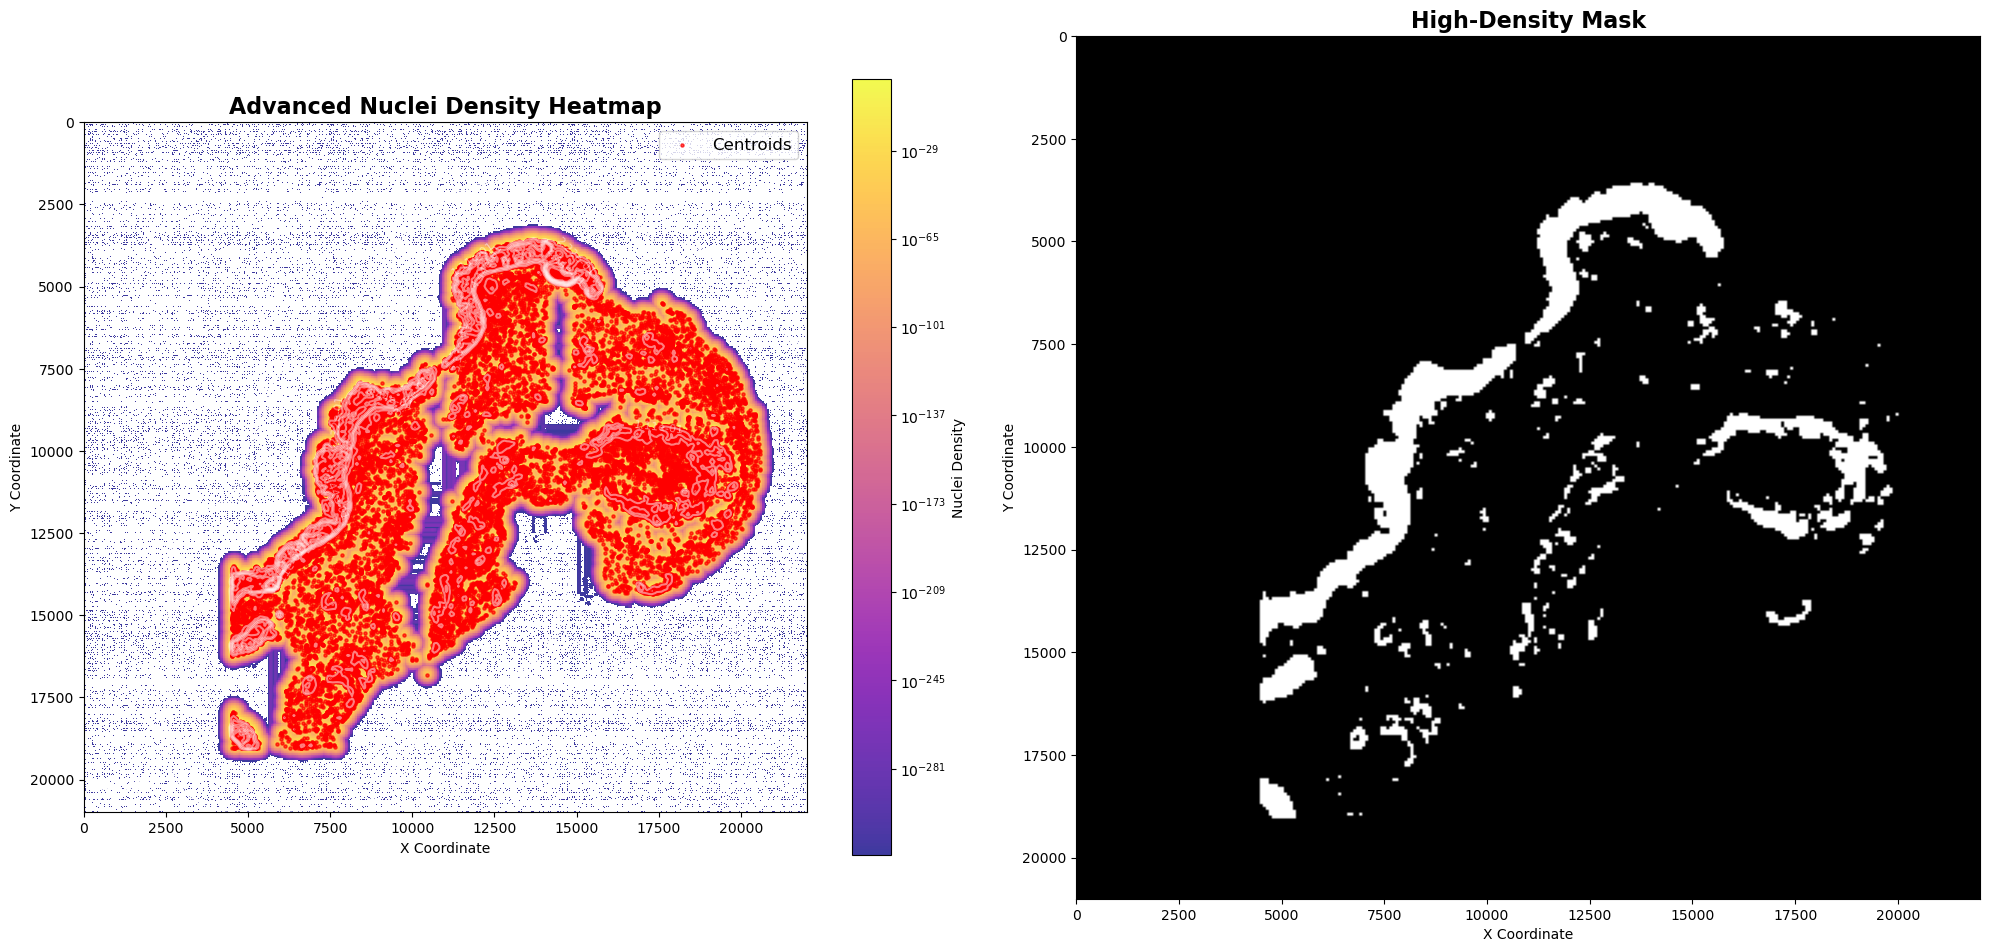

In [10]:



def generate_heatmap_and_mask(
        nuclei_image,
        bins=200,
        colormap="viridis",
        show_centroids=True,
        scale_bar=True,
        adaptive_bandwidth=True,
        dynamic_threshold=True,
        contour_features=True
):
    """
    Generate an advanced nuclei density heatmap and display it alongside the mask.

    Args:
        nuclei_image (np.ndarray): Binary nuclei image.
        bins (int): Number of bins for the heatmap.
        colormap (str): Colormap for the heatmap visualization.
        show_centroids (bool): Overlay nuclei centroids on the heatmap.
        scale_bar (bool): Add a scale bar to the heatmap.
        adaptive_bandwidth (bool): Use adaptive bandwidth for KDE.
        dynamic_threshold (bool): Use dynamic thresholding to highlight high-density regions.
        contour_features (bool): Add enhanced contour features to the heatmap.
    """
    # Extract nuclei centroids
    labeled_nuclei = label(nuclei_image)
    regions = regionprops(labeled_nuclei)
    centroids = np.array([region.centroid for region in regions])

    if centroids.size == 0:
        print("[WARNING] No nuclei detected. Skipping heatmap generation.")
        return

    # KDE Setup
    x_dim, y_dim = nuclei_image.shape[1], nuclei_image.shape[0]
    x = np.linspace(0, x_dim, bins)
    y = np.linspace(0, y_dim, bins)
    X, Y = np.meshgrid(x, y)

    if adaptive_bandwidth:
        kde = KernelDensity(kernel="gaussian", bandwidth=50)
        kde.fit(centroids)
        grid = np.vstack([Y.ravel(), X.ravel()]).T
        Z = np.exp(kde.score_samples(grid)).reshape(X.shape)
    else:
        kde = gaussian_kde(centroids.T, bw_method="scott")
        Z = kde(np.vstack([Y.ravel(), X.ravel()])).reshape(X.shape)

    # Normalize KDE Output
    Z /= Z.max()

    # Dynamic Thresholding
    if dynamic_threshold:
        threshold = np.percentile(Z, 95)  # Top 5% density regions
    else:
        threshold = np.mean(Z) + 2 * np.std(Z)

    # Create high-density mask
    high_density_mask = (Z > threshold).astype(np.uint8)

    # Plot Heatmap and Mask Side by Side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Heatmap
    heatmap = axes[0].imshow(
        Z, extent=(0, x_dim, y_dim, 0), cmap=colormap, alpha=0.8, norm=LogNorm()
    )
    axes[0].set_title("Advanced Nuclei Density Heatmap", fontsize=16, fontweight="bold")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    plt.colorbar(heatmap, ax=axes[0], label="Nuclei Density", shrink=0.8)

    if contour_features:
        contours = axes[0].contour(
            X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 10), colors="white", alpha=0.5
        )
        axes[0].clabel(contours, inline=True, fontsize=8, fmt="%.2e")

    if show_centroids:
        axes[0].scatter(
            centroids[:, 1],
            centroids[:, 0],
            c="red",
            s=5,
            label="Centroids",
            alpha=0.7,
        )
        axes[0].legend(loc="upper right", fontsize=12)

    if scale_bar:
        bar_length = 1000  # Adjust length based on image resolution
        axes[0].hlines(
            y_dim - 500, 100, 100 + bar_length, colors="white", linestyles="solid", lw=3
        )
        axes[0].text(
            100,
            y_dim - 700,
            f"{bar_length}px",
            color="white",
            fontsize=12,
            fontweight="bold",
        )

    # High-Density Mask
    axes[1].imshow(high_density_mask, cmap="gray", extent=(0, x_dim, y_dim, 0))
    axes[1].set_title("High-Density Mask", fontsize=16, fontweight="bold")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")

    plt.tight_layout()
    plt.show()


# Example Usage
nuclei_image = sdata.images["HE_nuc_original"].to_numpy().squeeze(0)
generate_heatmap_and_mask(
    nuclei_image,
    bins=300,
    colormap="plasma",
    show_centroids=True,
    dynamic_threshold=True,
    contour_features=True
)


[INFO] High-density mask saved to consolidated_high_density_mask.png
[INFO] Summary Statistics:
  - Total High-Density Area: 90.0000
  - Total Density: 2577.2972
  - Mean Density: 0.0286
  - Max Density: 1.0000
  - Dynamic Threshold: 0.0686


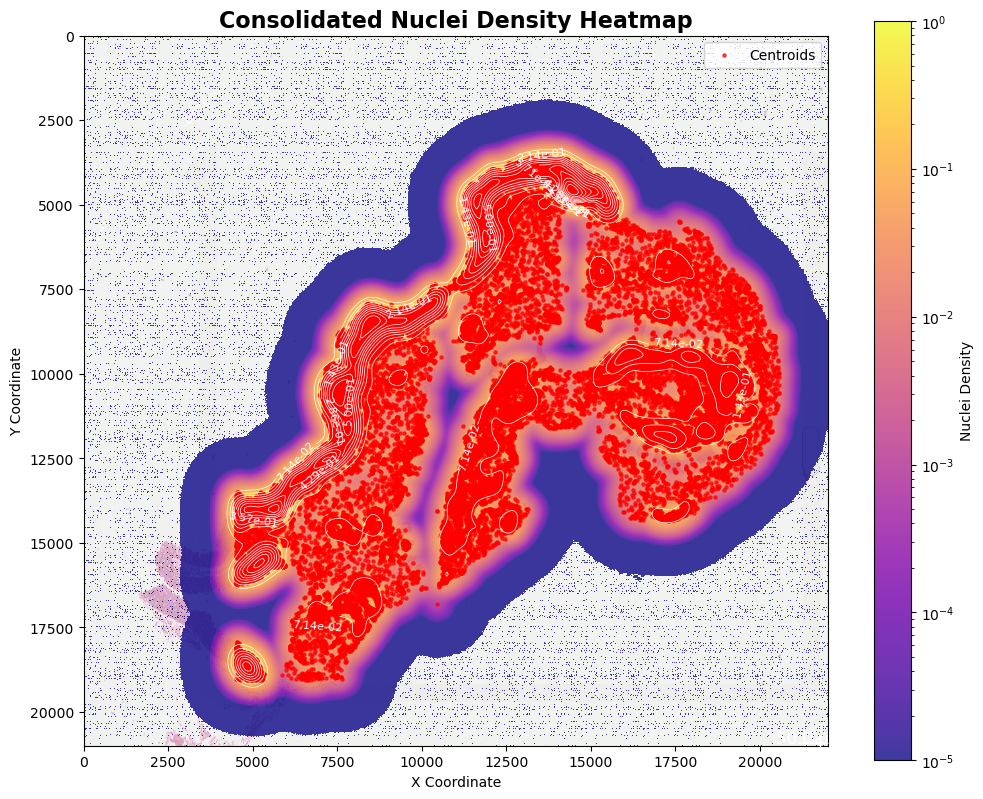

In [11]:

from matplotlib import colors
from matplotlib.patches import Rectangle
import cv2

def consolidated_density_heatmap(
        nuclei_image,
        background_image=None,
        bins=200,
        colormap="viridis",
        adaptive_bandwidth=True,
        dynamic_threshold=True,
        contour_features=True,
        show_centroids=True,
        scale_bar_length=500,
        save_mask_path="consolidated_high_density_mask.png",
        overlay_alpha=0.4,
        scale_factor=0.1
):
    """
    Generate an optimized and enhanced nuclei density heatmap.

    Args:
        nuclei_image (np.ndarray): Binary nuclei image.
        background_image (np.ndarray): Optional image layer for overlay.
        bins (int): Number of bins for the heatmap.
        colormap (str): Colormap for the heatmap visualization.
        adaptive_bandwidth (bool): Use adaptive bandwidth for KDE.
        dynamic_threshold (bool): Apply dynamic thresholding for high-density regions.
        contour_features (bool): Add enhanced contour features.
        show_centroids (bool): Overlay nuclei centroids on the heatmap.
        scale_bar_length (int): Length of the scale bar in image units.
        save_mask_path (str): Path to save the binary high-density mask.
        overlay_alpha (float): Transparency level for the overlay.
        scale_factor (float): Scale factor for the image resolution.

    Returns:
        dict: Summary statistics of the density map.
    """
    # Extract nuclei centroids
    labeled_nuclei = label(nuclei_image)
    regions = regionprops(labeled_nuclei)
    centroids = np.array([region.centroid for region in regions])

    if centroids.size == 0:
        print("[WARNING] No nuclei detected. Skipping heatmap generation.")
        return {}

    # KDE Setup
    x_dim, y_dim = nuclei_image.shape[1], nuclei_image.shape[0]
    x = np.linspace(0, x_dim, bins)
    y = np.linspace(0, y_dim, bins)
    X, Y = np.meshgrid(x, y)

    if adaptive_bandwidth:
        kde = KernelDensity(kernel="gaussian", bandwidth=200)
        kde.fit(centroids)
        grid = np.vstack([Y.ravel(), X.ravel()]).T
        Z = np.exp(kde.score_samples(grid)).reshape(X.shape)
    else:
        kde = gaussian_kde(centroids.T, bw_method="scott")
        Z = kde(np.vstack([Y.ravel(), X.ravel()])).reshape(X.shape)

    # Normalize KDE Output
    Z = Z / Z.max()

    # Dynamic Thresholding
    threshold = np.percentile(Z, 90) if dynamic_threshold else Z.mean() + 2 * Z.std()
    high_density_mask = (Z > threshold).astype(np.uint8)

    # Save high-density mask
    cv2.imwrite(save_mask_path, high_density_mask * 255)
    print(f"[INFO] High-density mask saved to {save_mask_path}")

    # Summary Statistics
    stats = {
        "Total High-Density Area": np.sum(high_density_mask) * scale_factor**2,
        "Total Density": np.sum(Z),
        "Mean Density": np.mean(Z),
        "Max Density": np.max(Z),
        "Dynamic Threshold": threshold,
    }
    print("[INFO] Summary Statistics:")
    for key, value in stats.items():
        print(f"  - {key}: {value:.4f}")

    # Plot Heatmap
    fig, ax = plt.subplots(figsize=(12, 12))

    # Optional Background Overlay
    if background_image is not None:
        ax.imshow(
            background_image.transpose(1, 2, 0) if background_image.ndim == 3 else background_image,
            cmap="gray",
            alpha=overlay_alpha
        )

    # Heatmap and Contours
    heatmap = ax.imshow(
        Z,
        extent=(0, x_dim, y_dim, 0),
        cmap=colormap,
        alpha=0.8,
        norm=colors.LogNorm(vmin=Z.min() + 1e-5, vmax=Z.max())
    )
    plt.colorbar(heatmap, ax=ax, label="Nuclei Density", shrink=0.8)

    if contour_features:
        contours = ax.contour(
            X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 15), colors="white", linewidths=0.5
        )
        ax.clabel(contours, inline=True, fontsize=8, fmt="%.2e")

    # Overlay Centroids
    if show_centroids:
        ax.scatter(centroids[:, 1], centroids[:, 0], c='red', s=5, label="Centroids", alpha=0.7)

    # Add Scale Bar
    scale_bar_x = x_dim - 1.5 * scale_bar_length
    scale_bar_y = y_dim - 100
    ax.add_patch(Rectangle((scale_bar_x, scale_bar_y), scale_bar_length, 20, color="white"))
    ax.text(
        scale_bar_x + scale_bar_length / 2, scale_bar_y + 40,
        f"{scale_bar_length * scale_factor} μm",
        color="white", fontsize=12, ha="center"
    )

    # Finalize the Plot
    ax.set_title("Consolidated Nuclei Density Heatmap", fontsize=16, fontweight="bold")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc="upper right", fontsize=10)
    plt.grid(False)
    plt.show()

    return stats

# Example Usage
background_layer = sdata.images["HE_original"].to_numpy()
nuclei_image = sdata.images["HE_nuc_original"].to_numpy().squeeze(0)
stats = consolidated_density_heatmap(
    nuclei_image=nuclei_image,
    background_image=background_layer,
    bins=300,
    colormap="plasma",
    adaptive_bandwidth=True,
    dynamic_threshold=True,
    contour_features=True,
    scale_bar_length=500,
    scale_factor=0.1
)


In [ ]:
from scipy.stats import gaussian_kde
from skimage.measure import regionprops, label
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, disk
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from matplotlib.colors import LogNorm


class NucleiDensityAnalyzer:
    """
    Class for analyzing nuclei density in biological images.

    This class generates high-resolution density heatmaps using Kernel Density Estimation (KDE),
    applies clustering techniques to refine high-density regions, and optionally performs
    morphological operations to smooth the mask. It is designed for precision and granularity
    in identifying regions of biological interest.
    """

    def __init__(self, nuclei_image: np.ndarray):
        """
        Initialize the analyzer with a binary nuclei image.

        Args:
            nuclei_image (np.ndarray): Binary image where non-zero pixels represent nuclei regions.
        """
        # Store the input binary image for analysis
        self.nuclei_image = nuclei_image

        # Label connected components in the binary image
        # Concept: Each connected group of pixels is treated as a separate nucleus.
        self.labeled_nuclei = label(nuclei_image)

        # Extract centroids of the labeled regions
        # Concept: Centroids are the "center of mass" of each labeled region,
        # and these serve as the basis for density estimation.
        print("[INFO] Extracting centroids from labeled nuclei...")
        self.centroids = np.array([
            region.centroid for region in tqdm(regionprops(self.labeled_nuclei), desc="Processing Regions")
            if region.area > 5  # Ignore small regions with an area less than 5 pixels
        ])

        # Raise an error if no centroids are detected
        if self.centroids.size == 0:
            raise ValueError("No nuclei centroids detected. Check the input image.")

        # Initialize placeholders for processed outputs
        self.high_density_mask = None  # Mask for high-density regions
        self.threshold = None  # Threshold value for high-density regions
        self.kde = None  # KDE model for density estimation

    def compute_kde_scores(self, grid_points):
        """
        Compute KDE scores for a grid of points.

        Args:
            grid_points (np.ndarray): Grid points where density is evaluated.

        Returns:
            np.ndarray: KDE scores for the given grid points.
        """
        # Calculate the density values at the given grid points
        return np.exp(self.kde.score_samples(grid_points))

    def generate_density_heatmap(
            self,
            bins: int = 300,  # Number of bins for the KDE grid (controls resolution)
            bandwidth: float = 30,  # Bandwidth for KDE (controls smoothness)
            dynamic_bandwidth: bool = True,  # Dynamically optimize bandwidth
            contour_features: bool = True,  # Include contour lines in the heatmap
            use_morphology: bool = True,  # Refine mask using morphological operations
            min_cluster_size: int = 10,  # Minimum size for clusters in clustering
            threshold_method: str = "percentile",  # Method for thresholding
            threshold_percentile: int = 90,  # Percentile for thresholding
            colormap: str = "viridis"  # Colormap for heatmap visualization
    ):
        """
        Generate a nuclei density heatmap and refine the high-density mask.

        Args:
            bins (int): Resolution of the KDE grid.
            bandwidth (float): Bandwidth for KDE; controls the smoothness of density estimation.
            dynamic_bandwidth (bool): Dynamically optimize KDE bandwidth based on data.
            contour_features (bool): Include contour lines on the heatmap.
            use_morphology (bool): Apply morphological operations to refine the mask.
            min_cluster_size (int): Minimum size for clusters to retain during clustering.
            threshold_method (str): Method for determining the threshold ("percentile" or "otsu").
            threshold_percentile (int): Percentile for determining the threshold (used if "percentile").
            colormap (str): Colormap for the heatmap.

        Returns:
            dict: Summary statistics of the density map.
        """
        # Dynamically optimize bandwidth if enabled
        bandwidth = bandwidth if not dynamic_bandwidth else self._optimize_bandwidth()

        # Configure and train the KDE model
        print("[INFO] Configuring KDE...")
        self.kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth)
        self.kde.fit(self.centroids)

        # Create a grid of points for KDE evaluation
        x_dim, y_dim = self.nuclei_image.shape[1], self.nuclei_image.shape[0]
        x = np.linspace(0, x_dim, bins)
        y = np.linspace(0, y_dim, bins)
        X, Y = np.meshgrid(x, y)
        grid_points = np.vstack([Y.ravel(), X.ravel()]).T

        # Compute KDE scores across the grid
        print("[INFO] Computing KDE scores...")
        Z = self.compute_kde_scores(grid_points).reshape(X.shape)
        Z /= Z.max()  # Normalize KDE scores to the range [0, 1]

        # Debug: Display statistics of the KDE matrix
        print("[DEBUG] KDE statistics:", {"min": Z.min(), "max": Z.max(), "mean": Z.mean()})

        # Determine the threshold for high-density regions
        if threshold_method == "percentile":
            self.threshold = np.percentile(Z, threshold_percentile)
        elif threshold_method == "otsu":
            self.threshold = threshold_otsu(Z)
        else:
            raise ValueError(f"Unsupported thresholding method: {threshold_method}")

        # Debug: Log thresholding details
        print("[DEBUG] Thresholding method:", threshold_method, "Threshold value:", self.threshold)

        # Create a binary mask for high-density regions
        self.high_density_mask = (Z > self.threshold).astype(np.uint8)

        # Apply clustering to identify and refine distinct regions
        print("[INFO] Applying clustering to identify distinct regions...")
        cluster_labels = self._apply_clustering(self.high_density_mask, min_cluster_size)
        self.high_density_mask = (cluster_labels > 0).astype(np.uint8)

        # Refine the mask using morphological operations (optional)
        if use_morphology:
            print("[INFO] Refining mask with morphological operations...")
            self.high_density_mask = binary_closing(self.high_density_mask, disk(3))

        # Plot the density heatmap and high-density mask
        self._plot_heatmap_and_mask(X, Y, Z, colormap, contour_features)

        # Return summary statistics
        stats = {
            "Total High-Density Area": np.sum(self.high_density_mask),
            "Mean Density": Z.mean(),
            "Max Density": Z.max(),
            "Threshold": self.threshold
        }
        print("[INFO] Summary Statistics:", stats)
        return stats

    def _apply_clustering(self, binary_mask, min_cluster_size):
        """
        Apply clustering to refine high-density regions.

        Args:
            binary_mask (np.ndarray): Binary mask of high-density regions.
            min_cluster_size (int): Minimum size for clusters to retain.

        Returns:
            np.ndarray: Clustered mask with distinct regions labeled.
        """
        # Extract coordinates of high-density regions
        coordinates = np.column_stack(np.nonzero(binary_mask))
        if len(coordinates) == 0:
            return np.zeros_like(binary_mask)

        # Perform clustering using DBSCAN
        clustering = DBSCAN(eps=10, min_samples=min_cluster_size).fit(coordinates)
        labels = clustering.labels_

        # Create a clustered mask
        clustered_mask = np.zeros_like(binary_mask, dtype=int)
        for coord, label in zip(coordinates, labels):
            if label >= 0:  # Ignore noise (label -1)
                clustered_mask[coord[0], coord[1]] = label + 1
        return clustered_mask

    def _optimize_bandwidth(self) -> float:
        """
        Optimize bandwidth using Silverman's rule of thumb.

        Returns:
            float: Optimized bandwidth.
        """
        return 1.06 * np.std(self.centroids) * (len(self.centroids) ** -0.2)

    def _plot_heatmap_and_mask(self, X, Y, Z, colormap, contour_features):
        """
        Plot the KDE density heatmap and high-density mask.

        Args:
            X (np.ndarray): X-coordinates of the grid.
            Y (np.ndarray): Y-coordinates of the grid.
            Z (np.ndarray): KDE density values.
            colormap (str): Colormap for the heatmap.
            contour_features (bool): Include contour lines on the heatmap.
        """
        # Create a figure with side-by-side visualizations
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))

        # Plot the KDE density heatmap
        heatmap = axes[0].imshow(Z, extent=(0, X.max(), Y.max(), 0), cmap=colormap, norm=LogNorm())
        plt.colorbar(heatmap, ax=axes[0], label="Nuclei Density")
        axes[0].set_title("Nuclei Density Heatmap")
        if contour_features:
            contours = axes[0].contour(X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 10), colors="white")
            axes[0].clabel(contours, inline=True, fontsize=8, fmt="%.2e")

        # Plot the binary mask for high-density regions
        axes[1].imshow(self.high_density_mask, cmap="gray", extent=(0, X.max(), Y.max(), 0))
        axes[1].set_title("High-Density Mask")

        plt.tight_layout()
        plt.show()


# Example Usage
# Load your binary nuclei image
nuclei_image = sdata.images["HE_nuc_original"].to_numpy().squeeze(0)

# Initialize the analyzer and generate heatmap
analyzer = NucleiDensityAnalyzer(nuclei_image)
stats = analyzer.generate_density_heatmap()


 ### 2.3.2 DBSCAN and Density-Based Clustering

#### 2.3.2.1 Basic DBSCAN with k-Distance Graph
In this step, we implement a DBSCAN approach to cluster nuclei. We calculate an optimal epsilon (`eps`) using a k-distance graph and apply the DBSCAN algorithm to the extracted nuclei features.

- **Steps**:
  1. Extract basic nuclei features: centroid, area, and eccentricity.
  2. Use a k-distance graph to determine the optimal epsilon (`eps`).
  3. Apply DBSCAN clustering to the nuclei features.
  4. Evaluate clustering quality using the following metrics:
     - **Silhouette Score**: Measures how similar each point is to its own cluster compared to other clusters.
     - **Davies-Bouldin Index**: Measures the ratio of within-cluster scatter to between-cluster separation.
     - **Calinski-Harabasz Score**: Measures the variance ratio between clusters.

- **Results**:
  - k-Distance Graph: Visual inspection for the elbow point to determine the optimal epsilon value.
  - Initial clustering evaluation metrics to benchmark performance.


[INFO] Extracted features for clustering:


,y,x,area,eccentricity,compactness
0,3566.400000,13657.646154,65.0,0.716349,0.083507
1,3566.821429,13672.660714,56.0,0.794176,0.071944
2,3570.781250,13732.437500,64.0,0.702644,0.077548
3,3569.578947,13647.736842,38.0,0.855387,0.075160
4,3573.089286,13561.178571,56.0,0.705382,0.083484


[INFO] Reduced features to 2 dimensions using PCA.


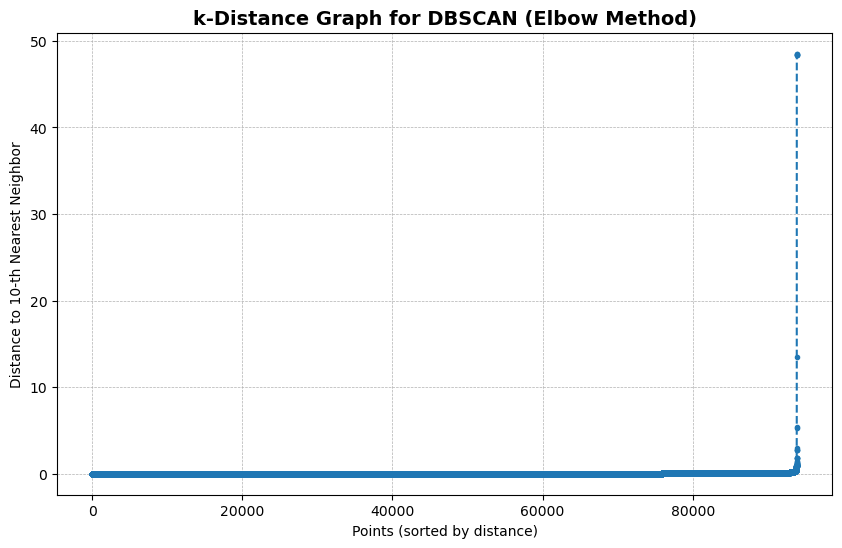

[INFO] Suggested epsilon (eps): 0.0443
[INFO] Silhouette Score: -0.3082
[INFO] Davies-Bouldin Index: 1.8639 (lower is better)
[INFO] Calinski-Harabasz Index: 127.9671 (higher is better)


In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler


def calculate_optimal_eps(features: np.ndarray, k: int = 5):
    """
    Calculate the optimal epsilon using k-distance graph for DBSCAN.

    Args:
        features (np.ndarray): Features for clustering.
        k (int): Number of nearest neighbors.

    Returns:
        float: Suggested value of epsilon based on the elbow method.
    """
    neighbors = NearestNeighbors(n_neighbors=k, n_jobs=-1)
    distances, _ = neighbors.fit(features).kneighbors(features)
    k_distances = np.sort(distances[:, -1])  # Sort distances to k-th neighbor

    # Plot k-distance graph for manual inspection
    plt.figure(figsize=(10, 6))
    plt.plot(k_distances, marker='o', linestyle='--', markersize=3)
    plt.title("k-Distance Graph for DBSCAN (Elbow Method)", fontsize=14, fontweight="bold")
    plt.xlabel("Points (sorted by distance)")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()

    # Suggest epsilon at the elbow (90th percentile)
    suggested_eps = np.percentile(k_distances, 90)
    print(f"[INFO] Suggested epsilon (eps): {suggested_eps:.4f}")
    return suggested_eps


def dbscan_with_advanced_metrics(nuclei_image: np.ndarray, min_samples: int = 5, k: int = 5, use_pca: bool = True):
    """
    Perform advanced DBSCAN clustering with full diagnostics and feature engineering.

    Args:
        nuclei_image (np.ndarray): Binary nuclei image.
        min_samples (int): Minimum samples for DBSCAN.
        k (int): Number of neighbors for epsilon estimation.
        use_pca (bool): Whether to use PCA for dimensionality reduction.

    Returns:
        pd.DataFrame: DataFrame with clustering results.
        np.ndarray: Cluster labels.
    """
    # Extract advanced nuclei features
    labeled_nuclei = label(nuclei_image)
    regions = regionprops(labeled_nuclei)
    features = []

    for region in regions:
        compactness = (region.area) / (region.perimeter ** 2) if region.perimeter > 0 else 0
        features.append([region.centroid[0], region.centroid[1], region.area, region.eccentricity, compactness])

    features_df = pd.DataFrame(features, columns=["y", "x", "area", "eccentricity", "compactness"])
    print("[INFO] Extracted features for clustering:")
    display(features_df.head())

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)

    # Optional PCA
    if use_pca:
        pca = IncrementalPCA(n_components=2)
        features_reduced = pca.fit_transform(features_scaled)
        print("[INFO] Reduced features to 2 dimensions using PCA.")
    else:
        features_reduced = features_scaled

    # Compute optimal epsilon
    eps = calculate_optimal_eps(features_reduced, k)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    cluster_labels = dbscan.fit_predict(features_reduced)
    features_df["cluster"] = cluster_labels

    # Evaluate clustering performance
    silhouette = silhouette_score(features_reduced, cluster_labels) if len(set(cluster_labels)) > 1 else -1
    db_score = davies_bouldin_score(features_reduced, cluster_labels) if len(set(cluster_labels)) > 1 else -1
    ch_score = calinski_harabasz_score(features_reduced, cluster_labels) if len(set(cluster_labels)) > 1 else -1

    print(f"[INFO] Silhouette Score: {silhouette:.4f}")
    print(f"[INFO] Davies-Bouldin Index: {db_score:.4f} (lower is better)")
    print(f"[INFO] Calinski-Harabasz Index: {ch_score:.4f} (higher is better)")
    return features_df, cluster_labels


# Example usage
dbscan_features_df, dbscan_labels = dbscan_with_advanced_metrics(nuclei_image, min_samples=10, k=10)


#### 2.3.2.2 Advanced DBSCAN with Diagnostics and Feature Engineering
Building upon the basic DBSCAN approach, we now introduce advanced diagnostics and feature engineering to improve clustering performance and interpretability.

- **Enhancements**:
  1. **Feature Engineering**:
     - Add compactness as a feature to better characterize nuclei shapes.
     - Optionally include intensity-based features (mean and standard deviation) for richer data representation.
  2. **Dimensionality Reduction**:
     - Use Incremental PCA to reduce feature dimensionality for large datasets, ensuring computational efficiency.
  3. **Evaluation Metrics**:
     - Evaluate clustering quality using silhouette score, Davies-Bouldin index, and Calinski-Harabasz score.
  4. **Visualization**:
     - Highlight outliers in clustering visualizations.
     - Provide enhanced plots to interpret clusters in the spatial context.

- **Results**:
  - Optimized epsilon and `min_samples` values based on diagnostics.
  - Improved clustering performance metrics.
  - Visualizations showcasing well-defined clusters and detected outliers.

- **Notes**:
  - Further tuning of parameters (e.g., `eps`, `min_samples`) may lead to better results.
  - Combining insights from density analysis (Step 2.3.1) can guide feature engineering and cluster interpretation.
